## Feature Extraction: 


Step one: Read the csv file, which pandas stores as a two dimensional array with labeled axes. 



In [26]:
import pandas as pd

from rake_nltk import Rake
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import warnings

from textblob import TextBlob
from textblob import Word

import seaborn as sns

import re
warnings.filterwarnings("ignore")
df = pd.read_csv('TAPAS_SCRAPED_DATA_complete.csv')
df.head()

Unnamed: 0                                     Topic Title       Category  \
0           0                   The Two Other Species (Novel)  Announcements   
1           1           “Lanche”, a textless comic [one-shot]  Announcements   
2           2       Moon Violations Unit - Episode 1 complete  Announcements   
3           3  Introducing Lauren, Community Marketing Intern  Announcements   
4           4       ✨⁠ Tapas Milestone Assets for Creators ✨⁠  Announcements   

                                        Leading Post  \
0  Hello everyone, My name is Genr not my real na...   
1  Hey there! \nDAKÍCORP's comics have been broug...   
2  Huge story ahead. Comments/Subs very welcome.\...   
3                                   Welcome Lauren!    
4                               Just need 4k more...   

                                        Post Replies        First Post Date  \
0                                                 []   Jul 19, 2021 3:11 am   
1                                                 []   Jul 18, 2021 5:54 pm   
2  ['What a great and refreshing new comic. (in r...   Jul 11, 2021 8:51 am   
3  ['Hi Lauren, welcome~ ', 'Oh dang! Welcome, La...   Jun 22, 2021 5:40 pm   
4  ['this is cool thanks! the milestone are edita...  May 26, 2021 11:49 am   

  Num Views                                        Num Replies  
0        53                           This topic has 0 replies  
1        59                           This topic has 0 replies  
2       109                           This topic has 4 replies  
3       342  This topic has 24 replies with an extremely hi...  
4       245  This topic has 10 replies with an extremely hi...

In [27]:
# keep only useful columns 
df = df[['Topic Title', 'Category','Leading Post', 'Post Replies']]


In [28]:
# collect useful information about dimensions, number of features, unique values
rows = df.shape[0]
cols = df.shape[1]
features = df.columns.tolist()
unique_vals = df.nunique()

print("rows x cols", rows, ' x ', cols)
print("Features: ", features)
print("\nUnique vals: ")
print(unique_vals)

rows x cols 9055  x  4
Features:  ['Topic Title', 'Category', 'Leading Post', 'Post Replies']

Unique vals: 
Topic Title     9055
Category          11
Leading Post    9024
Post Replies    8126
dtype: int64


In [29]:
# type of entries, and how many missing values/null fields
df.dropna(inplace=True)

df.info()
print("\nMissing values: ", df.isnull().sum().values.sum())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9034 entries, 0 to 9054
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Topic Title   9034 non-null   object
 1   Category      9034 non-null   object
 2   Leading Post  9034 non-null   object
 3   Post Replies  9034 non-null   object
dtypes: object(4)
memory usage: 352.9+ KB

Missing values:  0


Topic Title     0
Category        0
Leading Post    0
Post Replies    0
dtype: int64

In [30]:
# summary statistics for all numerical comments
df.describe().T

count unique                            top  freq
Topic Title   9034   9034  The Two Other Species (Novel)     1
Category      9034     11               Writing | Novels  1001
Leading Post  9034   9024                             []     6
Post Replies  9034   8108                             []   920

The next step is to do some basic feature extraction, starting with finding the number of words each of the Leading Posts. Create a new list, corresponding to the word counts, and apply a function to the the Leading Post column which takes a given string x, splits into a list of words, and then returns the length of that list.


In [31]:
df['word_count'] = df['Leading Post'].apply(lambda x: len(str(x).split(" ")))
df[['Leading Post','word_count']].head()

Leading Post  word_count
0  Hello everyone, My name is Genr not my real na...         258
1  Hey there! \nDAKÍCORP's comics have been broug...         126
2  Huge story ahead. Comments/Subs very welcome.\...           9
3                                   Welcome Lauren!            3
4                               Just need 4k more...           4

Similarly, let's find the number of characters in each Leading Post 


In [32]:
df['char_count'] = df['Leading Post'].str.len()
df[['Leading Post','char_count']].head()

Leading Post  char_count
0  Hello everyone, My name is Genr not my real na...        1490
1  Hey there! \nDAKÍCORP's comics have been broug...         744
2  Huge story ahead. Comments/Subs very welcome.\...          64
3                                   Welcome Lauren!           16
4                               Just need 4k more...          20

Now, let's find the average word length in a sentence. For this, it is simpler to create an outside function. 






In [33]:
def avg_word_len(sentence):
  words = sentence.split()
  return(sum(len(word) for word in words)/len(words))

df['avg_word_len'] = df['Leading Post'].apply(lambda x: avg_word_len(x))
df[['Leading Post','avg_word_len']].head()

Leading Post  avg_word_len
0  Hello everyone, My name is Genr not my real na...      4.590909
1  Hey there! \nDAKÍCORP's comics have been broug...      4.751938
2  Huge story ahead. Comments/Subs very welcome.\...      5.500000
3                                   Welcome Lauren!       7.000000
4                               Just need 4k more...      4.250000

## Text Preprocessing:

- remove white space
- remove stop words
- remove punctuation
- remove most common and least common words
- convert all words to lowercase
- exctract key words from Leading Post to list, using Rake

In [65]:
def remove_links_and_punctuation(df):
    df =  df.replace(to_replace = 'http\S+|www.\S+|@\S+|[0-9]\S+|KB|png|jpeg \S+', value = '', regex = True)
    df = df.replace(to_replace = '[^\\w\\s]', value = ' ', regex = True)
    for column_name in df:
        column = df[column_name]
        column = column.astype(str).str.lower() # convert to lowercase

        df[column_name] = column
    return(df)
df = remove_links_and_punctuation(df)

In [35]:
stop = stopwords.words('english')

def remove_stop_words(df):
    columns = df[['Leading Post', 'Post Replies']]
    for column_name in columns:
        column = df[column_name]
        column = column.astype(str).apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        df[column_name] = column
    return(df)
df = remove_stop_words(df)

In [36]:
def remove_most_common_words(df):
    columns = df[['Leading Post', 'Post Replies']]
    for column_name in columns:
        column = df[column_name]
        most_freq = pd.Series(" ".join(column).split()).value_counts()[:20]
        most_freq = list(most_freq.index)
        column = column.apply(lambda x: " ".join(x for x in x.split() if x not in most_freq))
        df[column_name] = column

        #Testing:
        #print("top 25 most frequent words in category : ", df[column_name].name, most_freq)

    return(df)

def remove_rarest_words(df):
    columns = df[['Leading Post', 'Post Replies']]
    for column_name in columns:
        column = df[column_name]
        least_freq = pd.Series(" ".join(column).split()).value_counts()[-20:]
        least_freq = list(least_freq.index)
        column = column.apply(lambda x: " ".join(x for x in x.split() if x not in least_freq))
        df[column_name] = column
        #Testing:
        #print("top 25 rarest words in category :  ", df[column_name].name, least_freq)
    return(df)

df = remove_most_common_words(df)
df = remove_rarest_words(df)

Tokenization - the process of dividing text into a sequence of words or sentences. 

In [37]:
nltk.download('punkt')
TextBlob(df['Leading Post'][1]).words


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mariamihaila/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


WordList(['hey', 'dakícorp', 'brought', 'brazilian', 'portuguese', 'recently', 'café', 'espacial', 'lauched', 'contest', 'printed', 'issue', 'theme', 'without', 'words', '5', 'pages', 'max', 'per', 'wife', 'always', 'wanted', 'create', 'something', 'together', 'since', 'beginning', 'relationship', 'saw', 'nice', 'opportunity', 'experiment', 'handled', 'writing', 'responsible', 'drawings', 'lanche', 'selected', 'ones', 'enjoyed', 'working', 'together', 'quick', 'read', 'interested', 'already', 'available', 'lanche', 'textless', 'marina', 'de', 'carvalho', 'marcelo', 'dakí2'])

Lemmatizing - this converts all words to their root


In [38]:
nltk.download('wordnet')
df['Leading Post'] = df['Leading Post'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
print(df['Leading Post'].head())


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mariamihaila/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    hello everyone name genr real name teenager po...
1    hey dakícorp brought brazilian portuguese rece...
2           huge ahead comment sub welcome mvu episode
3                                       welcome lauren
4                                                 need
Name: Leading Post, dtype: object


## Data Visualizations :)

Category Distribution: 

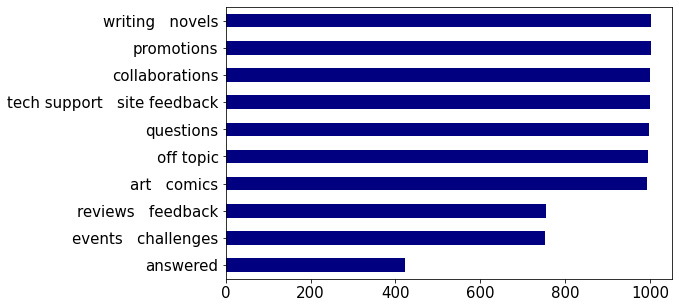

In [39]:
df['Category'].value_counts()[0 : 10].plot(kind = 'barh', figsize = [8,5],fontsize=15, color='navy').invert_yaxis()

An **N - gram** is a combination of multiple words often found together, and a N-gram model can be used to predict the probability that a word will occur after a text sequence. For example; an N - gram ( specifically, a bigram) would be something like "Covid-19 pandmenic" and the probability that "pandemic" will follow "Covid-19" is higher than "joy" following "Covid-19"

In [68]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

Bigrams Graphs -


Text(0.5, 1.0, 'Leading Post Bigrams')

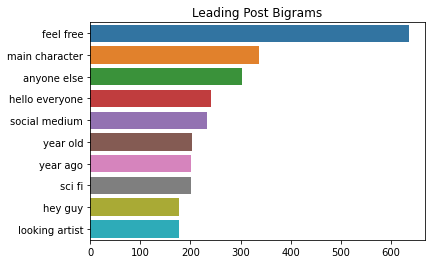

In [66]:
import seaborn as sns

#bigrams for Leading Post Data
top_n_bigrams=get_top_ngram(df['Leading Post'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
ax = sns.barplot(x=y,y=x)
ax.set_title("Leading Post Bigrams")

Text(0.5, 1.0, 'Post Replies Bigrams')

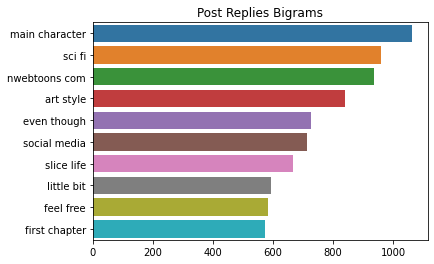

In [69]:
#bigrams for Post Replies data
top_n_bigrams=get_top_ngram(df['Post Replies'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
ax = sns.barplot(x=y,y=x)
ax.set_title('Post Replies Bigrams')

Trigrams Graphs:

Text(0.5, 1.0, 'Leading Post Trigrams')

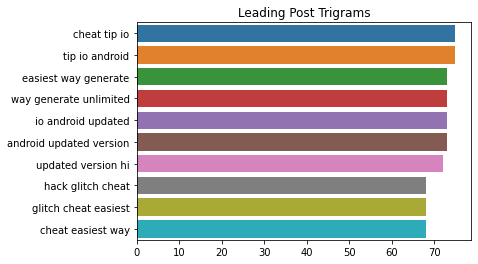

In [70]:
top_tri_grams=get_top_ngram(df['Leading Post'],n=3)
x,y=map(list,zip(*top_tri_grams))
ax = sns.barplot(x=y,y=x)
ax.set_title("Leading Post Trigrams")

Text(0.5, 1.0, 'Post Replies Trigrams')

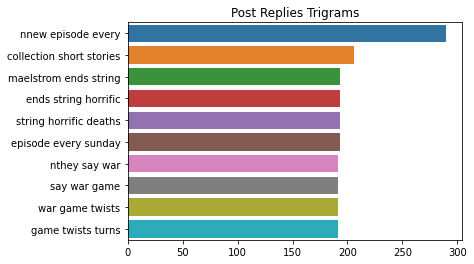

In [71]:
top_tri_grams=get_top_ngram(df['Post Replies'],n=3)
x,y=map(list,zip(*top_tri_grams))
ax = sns.barplot(x=y,y=x)
ax.set_title("Post Replies Trigrams")

In [82]:
%matplotlib inline

from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

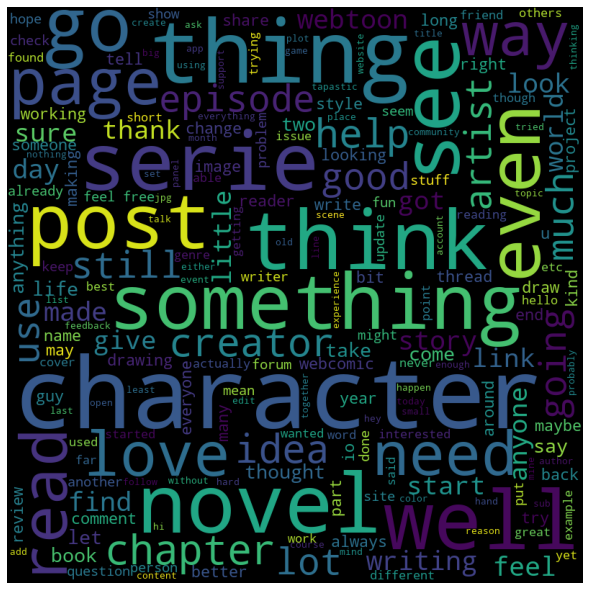

In [84]:
texts = ''
for index, item in df.iterrows():
    texts = texts + ' ' + item['Leading Post']
    
plot_word_cloud(texts)

In [92]:
df.rename(columns={"Category": "category"}, inplace=True)


In [95]:
df['category'] = df['category'].replace(to_replace = "  ", value = " ", regex = True)
df['category'].unique()

array(['announcements', 'events challenges', 'off topic', 'art comics',
       'writing novels', 'reviews feedback', 'collaborations',
       'questions', 'answered', 'tech support site feedback',
       'promotions'], dtype=object)

In [101]:
def plot_word_cloud_for_category(df, category):
  text_df = df.loc[df['category'] == str(category)]
  texts = ''
  for index, item in text_df.iterrows():
    texts = texts + ' ' + item['Leading Post']
  plot_word_cloud(texts)

In [97]:
df.category.unique()

array(['announcements', 'events challenges', 'off topic', 'art comics',
       'writing novels', 'reviews feedback', 'collaborations',
       'questions', 'answered', 'tech support site feedback',
       'promotions'], dtype=object)

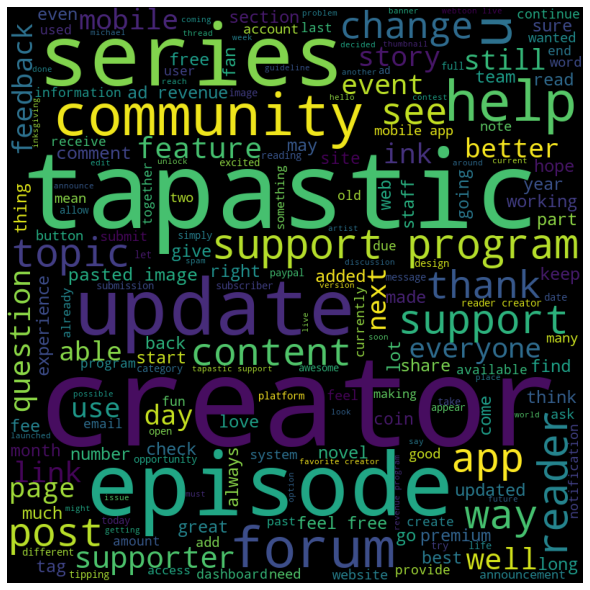

In [102]:
plot_word_cloud_for_category(df, 'announcements')

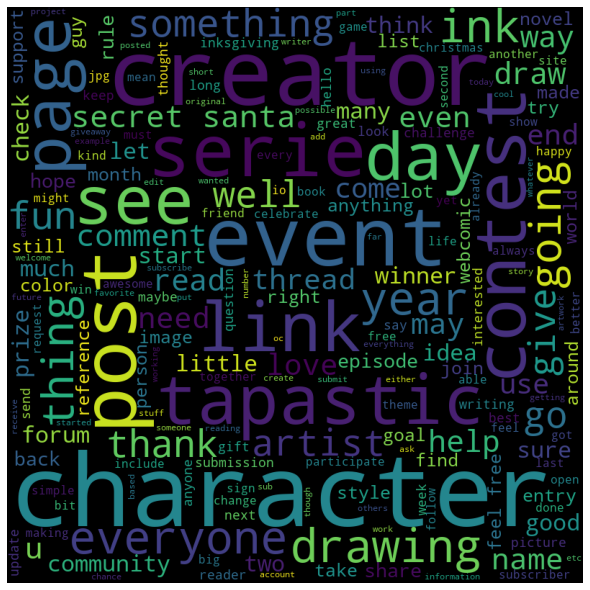

In [103]:
plot_word_cloud_for_category(df, 'events challenges')

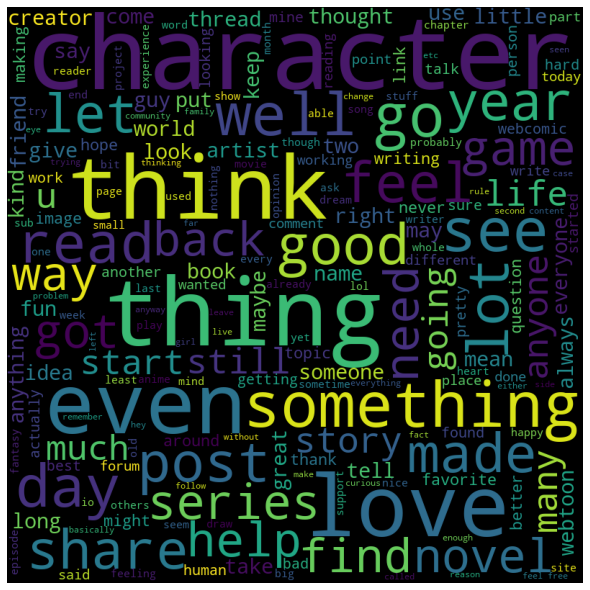

In [104]:
plot_word_cloud_for_category(df, 'off topic')

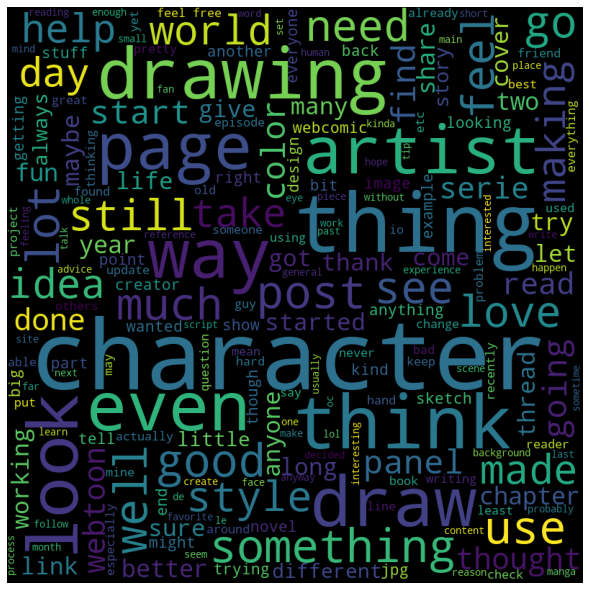

In [105]:
plot_word_cloud_for_category(df, 'art comics')

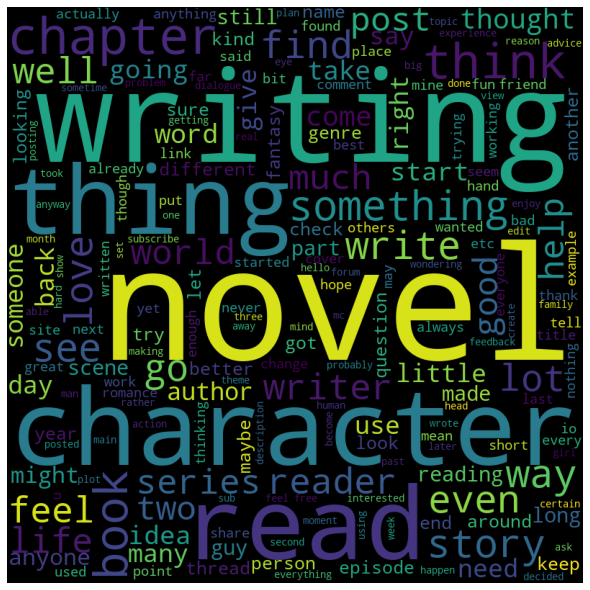

In [106]:
plot_word_cloud_for_category(df, 'writing novels')

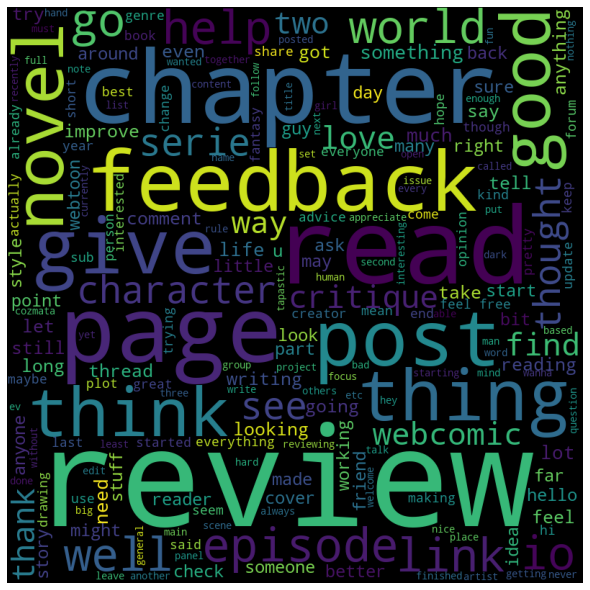

In [107]:
plot_word_cloud_for_category(df, 'reviews feedback')

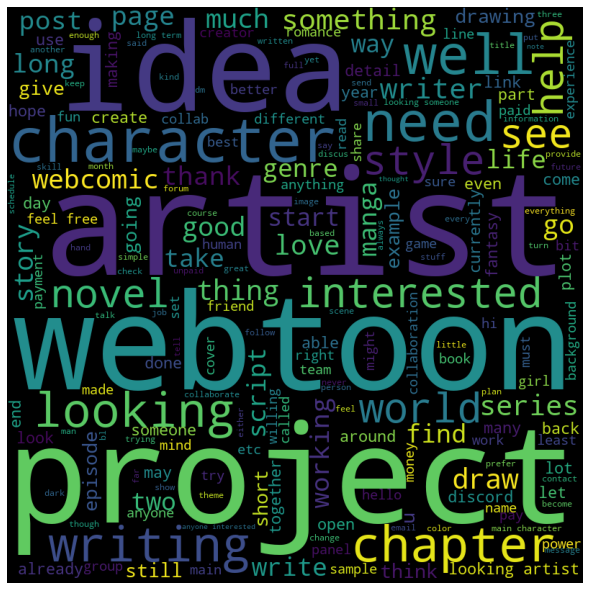

In [108]:
plot_word_cloud_for_category(df, 'collaborations')

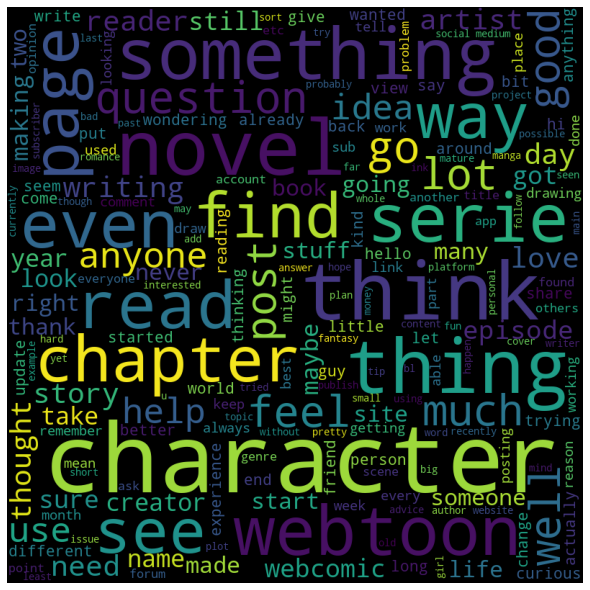

In [109]:
plot_word_cloud_for_category(df, 'questions')

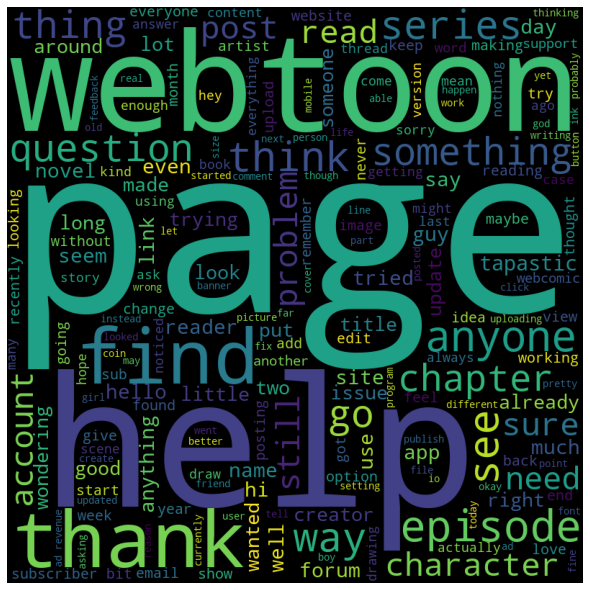

In [110]:
plot_word_cloud_for_category(df, 'answered')

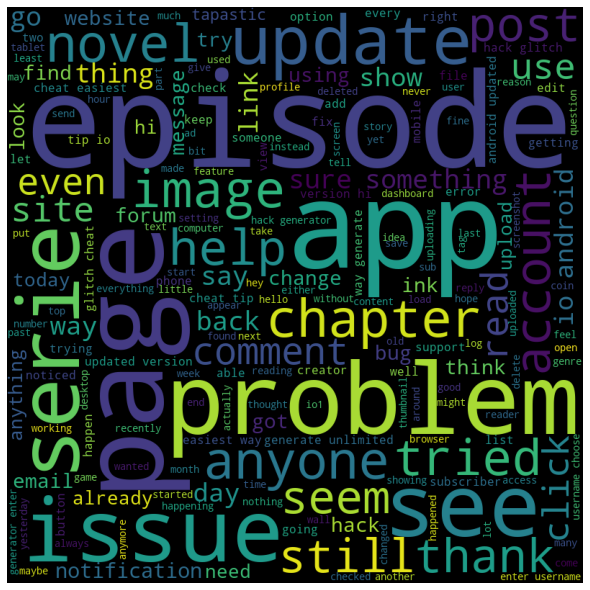

In [111]:
plot_word_cloud_for_category(df, 'tech support site feedback')

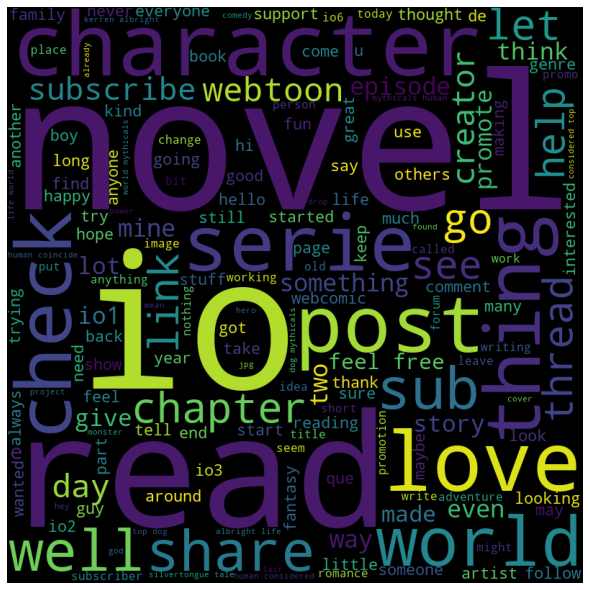

In [112]:
plot_word_cloud_for_category(df, 'promotions')

**TF (Text Frequency)** is simply the ratio that a word appears to the length of the sentence it is present in

> TF = (Number of times term T appears in the particular row) / (number of terms in that row)

Obviously, the higher the TF - the more relevant the word in the given context



In [45]:
tf1 = (df['Leading Post'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

words  tf
0       together   2
1         lanche   2
2            hey   1
3   relationship   1
4           nice   1
5    opportunity   1
6     experiment   1
7        handled   1
8        writing   1
9    responsible   1
10       drawing   1
11      selected   1
12           one   1
13       enjoyed   1
14       working   1
15         quick   1
16          read   1
17    interested   1
18       already   1
19     available   1
20      textless   1
21        marina   1
22            de   1
23      carvalho   1
24       marcelo   1
25           saw   1
26     beginning   1
27      dakícorp   1
28         theme   1
29       brought   1
30     brazilian   1
31    portuguese   1
32      recently   1
33          café   1
34      espacial   1
35       lauched   1
36       contest   1
37       printed   1
38         issue   1
39       without   1
40         since   1
41          word   1
42             5   1
43          page   1
44           max   1
45           per   1
46          wife   1
47        always   1
48        wanted   1
49        create   1
50     something   1
51         dakí2   1

**IDF - inverse document frequency**

> IDF = log(N/n) 

where N = # of documents, and n = # of documents a term appears in





In [46]:
import numpy as np
for i,word in enumerate(tf1['words']):
      tf1.loc[i, 'idf'] = np.log(df.shape[0]/(len(df[df['Leading Post'].str.contains(word)])))
tf1                                                     

words  tf       idf
0       together   2  2.898150
1         lanche   2  8.415603
2            hey   1  2.393367
3   relationship   1  4.098115
4           nice   1  3.217106
5    opportunity   1  4.363818
6     experiment   1  4.474022
7        handled   1  6.543801
8        writing   1  2.157936
9    responsible   1  5.707553
10       drawing   1  2.563401
11      selected   1  5.674763
12           one   1  0.747276
13       enjoyed   1  5.196728
14       working   1  2.376540
15         quick   1  3.449268
16          read   1  1.013457
17    interested   1  2.266067
18       already   1  2.579332
19     available   1  3.961256
20      textless   1  9.108751
21        marina   1  6.400700
22            de   1  0.347827
23      carvalho   1  9.108751
24       marcelo   1  8.415603
25           saw   1  3.867004
26     beginning   1  3.780874
27      dakícorp   1  9.108751
28         theme   1  3.517764
29       brought   1  4.919096
30     brazilian   1  7.316991
31    portuguese   1  6.623844
32      recently   1  2.937050
33          café   1  7.499313
34      espacial   1  8.415603
35       lauched   1  9.108751
36       contest   1  4.002805
37       printed   1  5.643015
38         issue   1  3.051967
39       without   1  2.951772
40         since   1  2.111155
41          word   1  2.745722
42             5   1  3.063745
43          page   1  2.092141
44           max   1  4.544402
45           per   1  1.166744
46          wife   1  5.471164
47        always   1  2.595520
48        wanted   1  2.669400
49        create   1  2.559100
50     something   1  1.837047
51         dakí2   1  9.108751

Putting it all together with **TF-IDF: Term Frequency - Inverse Document Frequency**

```
TF-IDF (word, Document#) = TF * IDF
```


The higher the tf - idf score, the more important a word is! 

In [47]:
tf1['tfidf'] = tf1['tf']*tf1['idf']
tf1

words  tf       idf      tfidf
0       together   2  2.898150   5.796301
1         lanche   2  8.415603  16.831207
2            hey   1  2.393367   2.393367
3   relationship   1  4.098115   4.098115
4           nice   1  3.217106   3.217106
5    opportunity   1  4.363818   4.363818
6     experiment   1  4.474022   4.474022
7        handled   1  6.543801   6.543801
8        writing   1  2.157936   2.157936
9    responsible   1  5.707553   5.707553
10       drawing   1  2.563401   2.563401
11      selected   1  5.674763   5.674763
12           one   1  0.747276   0.747276
13       enjoyed   1  5.196728   5.196728
14       working   1  2.376540   2.376540
15         quick   1  3.449268   3.449268
16          read   1  1.013457   1.013457
17    interested   1  2.266067   2.266067
18       already   1  2.579332   2.579332
19     available   1  3.961256   3.961256
20      textless   1  9.108751   9.108751
21        marina   1  6.400700   6.400700
22            de   1  0.347827   0.347827
23      carvalho   1  9.108751   9.108751
24       marcelo   1  8.415603   8.415603
25           saw   1  3.867004   3.867004
26     beginning   1  3.780874   3.780874
27      dakícorp   1  9.108751   9.108751
28         theme   1  3.517764   3.517764
29       brought   1  4.919096   4.919096
30     brazilian   1  7.316991   7.316991
31    portuguese   1  6.623844   6.623844
32      recently   1  2.937050   2.937050
33          café   1  7.499313   7.499313
34      espacial   1  8.415603   8.415603
35       lauched   1  9.108751   9.108751
36       contest   1  4.002805   4.002805
37       printed   1  5.643015   5.643015
38         issue   1  3.051967   3.051967
39       without   1  2.951772   2.951772
40         since   1  2.111155   2.111155
41          word   1  2.745722   2.745722
42             5   1  3.063745   3.063745
43          page   1  2.092141   2.092141
44           max   1  4.544402   4.544402
45           per   1  1.166744   1.166744
46          wife   1  5.471164   5.471164
47        always   1  2.595520   2.595520
48        wanted   1  2.669400   2.669400
49        create   1  2.559100   2.559100
50     something   1  1.837047   1.837047
51         dakí2   1  9.108751   9.108751

It turns out that you don't need to calculate TF-IDF manually all the time, since there is the ski-kit learn library can do all of this automatically. 

In [48]:

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(df['Leading Post'])
train_vect

<9034x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 248883 stored elements in Compressed Sparse Row format>

In [49]:
print(train_vect)

  (0, 441)	0.05951179718883825
  (0, 454)	0.07601292419386102
  (0, 172)	0.06926754755306212
  (0, 83)	0.06413183074894498
  (0, 334)	0.10022000156478153
  (0, 145)	0.15662612704875248
  (0, 116)	0.11002322273580349
  (0, 478)	0.09152255522648185
  (0, 358)	0.056374748138840323
  (0, 507)	0.07775473732192718
  (0, 29)	0.09234767164595017
  (0, 143)	0.05614299149733039
  (0, 40)	0.09525192534825265
  (0, 255)	0.09476001351663516
  (0, 414)	0.13883681128493025
  (0, 193)	0.10697342298776119
  (0, 84)	0.18555065372648172
  (0, 477)	0.15202584838772204
  (0, 908)	0.14642204000603287
  (0, 750)	0.17148676177140226
  (0, 570)	0.17286420235860564
  (0, 531)	0.14815892209555842
  (0, 595)	0.1317942847069866
  (0, 236)	0.17347158167608515
  (0, 21)	0.13808735268509897
  :	:
  (9032, 79)	0.29931513867989
  (9032, 657)	0.3199953291168659
  (9032, 534)	0.2623343017082006
  (9032, 855)	0.32268639472023025
  (9032, 234)	0.2601789210553545
  (9032, 862)	0.2645707581767732
  (9032, 479)	0.260759046643

In [50]:
tf2 = (df['Leading Post'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf2.columns = ['words','tf']
tf2

words  tf
0       together   2
1         lanche   2
2            hey   1
3   relationship   1
4           nice   1
5    opportunity   1
6     experiment   1
7        handled   1
8        writing   1
9    responsible   1
10       drawing   1
11      selected   1
12           one   1
13       enjoyed   1
14       working   1
15         quick   1
16          read   1
17    interested   1
18       already   1
19     available   1
20      textless   1
21        marina   1
22            de   1
23      carvalho   1
24       marcelo   1
25           saw   1
26     beginning   1
27      dakícorp   1
28         theme   1
29       brought   1
30     brazilian   1
31    portuguese   1
32      recently   1
33          café   1
34      espacial   1
35       lauched   1
36       contest   1
37       printed   1
38         issue   1
39       without   1
40         since   1
41          word   1
42             5   1
43          page   1
44           max   1
45           per   1
46          wife   1
47        always   1
48        wanted   1
49        create   1
50     something   1
51         dakí2   1

In [51]:
import numpy as np

for i,word in enumerate(tf2['words']):
      tf2.loc[i, 'idf'] = np.log(df.shape[0]/(len(df[df['Leading Post'].str.contains(word)])))

tf2

words  tf       idf
0       together   2  2.898150
1         lanche   2  8.415603
2            hey   1  2.393367
3   relationship   1  4.098115
4           nice   1  3.217106
5    opportunity   1  4.363818
6     experiment   1  4.474022
7        handled   1  6.543801
8        writing   1  2.157936
9    responsible   1  5.707553
10       drawing   1  2.563401
11      selected   1  5.674763
12           one   1  0.747276
13       enjoyed   1  5.196728
14       working   1  2.376540
15         quick   1  3.449268
16          read   1  1.013457
17    interested   1  2.266067
18       already   1  2.579332
19     available   1  3.961256
20      textless   1  9.108751
21        marina   1  6.400700
22            de   1  0.347827
23      carvalho   1  9.108751
24       marcelo   1  8.415603
25           saw   1  3.867004
26     beginning   1  3.780874
27      dakícorp   1  9.108751
28         theme   1  3.517764
29       brought   1  4.919096
30     brazilian   1  7.316991
31    portuguese   1  6.623844
32      recently   1  2.937050
33          café   1  7.499313
34      espacial   1  8.415603
35       lauched   1  9.108751
36       contest   1  4.002805
37       printed   1  5.643015
38         issue   1  3.051967
39       without   1  2.951772
40         since   1  2.111155
41          word   1  2.745722
42             5   1  3.063745
43          page   1  2.092141
44           max   1  4.544402
45           per   1  1.166744
46          wife   1  5.471164
47        always   1  2.595520
48        wanted   1  2.669400
49        create   1  2.559100
50     something   1  1.837047
51         dakí2   1  9.108751

In [52]:
tf2['tfidf'] = tf2['tf'] * tf2['idf']


In [53]:

compare = pd.DataFrame({"words": tf1["words"],
                        "tf1_result": tf1['tfidf'],
                        "tf2_result": tf2['tfidf']})
compare

words  tf1_result  tf2_result
0       together    5.796301    5.796301
1         lanche   16.831207   16.831207
2            hey    2.393367    2.393367
3   relationship    4.098115    4.098115
4           nice    3.217106    3.217106
5    opportunity    4.363818    4.363818
6     experiment    4.474022    4.474022
7        handled    6.543801    6.543801
8        writing    2.157936    2.157936
9    responsible    5.707553    5.707553
10       drawing    2.563401    2.563401
11      selected    5.674763    5.674763
12           one    0.747276    0.747276
13       enjoyed    5.196728    5.196728
14       working    2.376540    2.376540
15         quick    3.449268    3.449268
16          read    1.013457    1.013457
17    interested    2.266067    2.266067
18       already    2.579332    2.579332
19     available    3.961256    3.961256
20      textless    9.108751    9.108751
21        marina    6.400700    6.400700
22            de    0.347827    0.347827
23      carvalho    9.108751    9.108751
24       marcelo    8.415603    8.415603
25           saw    3.867004    3.867004
26     beginning    3.780874    3.780874
27      dakícorp    9.108751    9.108751
28         theme    3.517764    3.517764
29       brought    4.919096    4.919096
30     brazilian    7.316991    7.316991
31    portuguese    6.623844    6.623844
32      recently    2.937050    2.937050
33          café    7.499313    7.499313
34      espacial    8.415603    8.415603
35       lauched    9.108751    9.108751
36       contest    4.002805    4.002805
37       printed    5.643015    5.643015
38         issue    3.051967    3.051967
39       without    2.951772    2.951772
40         since    2.111155    2.111155
41          word    2.745722    2.745722
42             5    3.063745    3.063745
43          page    2.092141    2.092141
44           max    4.544402    4.544402
45           per    1.166744    1.166744
46          wife    5.471164    5.471164
47        always    2.595520    2.595520
48        wanted    2.669400    2.669400
49        create    2.559100    2.559100
50     something    1.837047    1.837047
51         dakí2    9.108751    9.108751

## Sentiment Analysis

In [54]:
df['Sentiment'] = df['Leading Post'].apply(lambda x: TextBlob(x).sentiment[0])
df[['Leading Post','Sentiment']].head()

Leading Post  Sentiment
0  hello everyone name genr real name teenager po...   0.122028
1  hey dakícorp brought brazilian portuguese rece...   0.326190
2         huge ahead comment sub welcome mvu episode   0.600000
3                                     welcome lauren   0.800000
4                                               need   0.000000